<a href="https://colab.research.google.com/github/umbertogagl97/Tesi/blob/main/Impronte/AttaccoScanner/Attacco_DeepFool_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Init**

##Import ART

In [1]:
#importa ART
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1 MB 7.9 MB/s 
     |████████████████████████████████| 3.3 MB 66.3 MB/s 
     |████████████████████████████████| 26.3 MB 64.2 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


## Import librerie

In [2]:
#Librerie

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
#import time
#import os
#import shutil
#import copy

import pandas as pd
import matplotlib.pyplot as plt
import sys

from torchvision.transforms.functional import InterpolationMode

from torch.utils.data import TensorDataset, DataLoader

import cv2
from google.colab.patches import cv2_imshow

##Check device


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.9.0+cu111
True
Tesla P100-PCIE-16GB
cuda:0


##Def path

In [4]:
#scanner
scanner_name = 'HiScan'

#load modello
path_model = F"/content/gdrive/My Drive/Scanner/{scanner_name}" 

#dataset
pathTestset=F'/content/gdrive/MyDrive/Dataset_impronte/test/{scanner_name}'

#predizioni testset originale
pd_preds=F'/content/gdrive/MyDrive/Dataset_impronte/test/Preds_value/{scanner_name}_con_normalize.xlsx'

##Collegamento google drive

In [5]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Transforms

In [7]:
transf_init=transforms.Resize(size=(1000,1000),interpolation=InterpolationMode.NEAREST)

data_transform_test= transforms.Compose([transforms.Resize([224,224],interpolation=InterpolationMode.NEAREST),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
transf_resize=transforms.Resize([224,224],interpolation=InterpolationMode.NEAREST)

transf_load= transforms.Compose([transforms.ToTensor(),
                                 #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
trans_norm=transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


#**Dataset**

##Caricamento dataset

In [8]:
test_dataset = datasets.ImageFolder(pathTestset,transform=transf_load)
dim_set=len(test_dataset)
print(dim_set)

2500


##Dataloader

In [9]:
testgen=torch.utils.data.DataLoader(test_dataset, pin_memory=True, batch_size=1,num_workers=2)

##Nomi classi

In [10]:
classes_name=test_dataset.classes
class_number=len(classes_name)
print(classes_name)
print(class_number)
#del test_dataset

['Live', 'Spoof']
2


##Min Max dataset

In [11]:
a,_=next(iter(testgen))
_min,_max=torch.min(a),torch.max(a)
print(_min,_max)

tensor(0.) tensor(1.)


#**Riduzione dataset**

In [12]:
test_dataset.samples=test_dataset.samples[1004:1005]

dim_set=len(test_dataset)
print(dim_set)

1


# **Creazione modello**

> non ho bloccato i parametri inferiori e sbloccato quelli del classificatore, vedi se funziona



##Load model pre-trained

In [13]:
model = models.vgg19(pretrained=True,progress=True)
#model = models.densenet201(pretrained=True,progress=True)
#print(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

##Aggiunta classificatore

In [14]:
model.classifier[6]=nn.Linear(4096,2) #per vgg19
#model.classifier=nn.Linear(1920,2) #per densenet201

#print(model) 

##Load pesi

In [15]:
model.load_state_dict(torch.load(path_model))#,map_location=torch.device('cpu')))


<All keys matched successfully>

# **Def funzioni**

##calc size

In [16]:
def calc_size(n):
  '''
  n: int 
  return: 80% of n
  '''
  return tuple(int(np.ceil(i * (80/100))) for i in n)

##Perturbazione

In [17]:
def compute_perturb(x,x_adv):
  '''
    x: img originali
    x_adv: img contraddittorie
    return: pertubazioni
  '''
  if x_adv.shape[2]!=1000:
    x=np.array(transf_resize(torch.Tensor(x)))
  perturb=x_adv-x
  
  if perturb.shape[2]!=1000:
    perturb=np.array(transf_init(torch.Tensor(perturb)))
  
  return perturb

##Print subplot

In [18]:
def print_subplot(perturb,x_test,y_test,preds,x_test_adv,value_preds_adv):
  '''
    perturb: perturbazioni
    x_test: img originali
    y_test: classi originali
    preds: classi predette per img originali
    x_test_adv: img contraddittoria
    value_preds_adv: probabilità predette img contraddittorie
    normalize: se True normalizza le immagini
  '''

  #nel seguente ciclo for si crea un vettore delle classi predette ordinato per probabilità decrescente
  for i in range(len(x_test)):#(x_test.shape[0]):
    value=value_preds_adv[i]*100
    value_sorted=sorted(value,reverse=True)
    classes=[]
    for j in range(value.size) :
      ind=np.where(value==value_sorted[j]) #restituisce l'indice in value del valore uguale a value_sorted[i], quindi è la classe
      classes.append(classes_name[ind[0][0]]) #classes è il vettore finale
    
    value_sorted=[ round(elem, 2) for elem in value_sorted ]

    val_pert=np.mean(np.abs(perturb[i]))
    pert_min,pert_max=np.min(perturb[i]),np.max(perturb[i])
    #perturb,val_pert,perturb_norm=compute_perturb(x_test,x_test_adv)
    perturb[i]=np.clip(perturb[i],0,1) #rimuovo i valori negativi poiché non posso visualizzarli
    #in seguito per ogni immagine del test set si stampa un subplot
    fig = plt.figure(figsize=[20,20])
    #plt.subplots_adjust(wspace=0.9)
    print('\033[1m'+"IMMAGINE "+'\033[1m',i) #valore END: '\033[0m'
    #originale
    ax1 = fig.add_subplot(131) #subplot con 3 righe e due colonne
    ax1.axis('off')
    #ax1.imshow(cv2.rotate(x_test[i],cv2.cv2.ROTATE_90_CLOCKWISE))
    ax1.imshow(x_test[i].transpose(1,2,0))
    ax1.title.set_text("ORIGINALE\nclasse reale: "+classes_name[np.argmax(y_test[i])]+"\nclasse predetta: "+str(classes_name[preds[i]]))
    #perturbazione
    ax2 = fig.add_subplot(132)
    #ax2.imshow(cv2.rotate(perturb_norm[i],cv2.cv2.ROTATE_90_CLOCKWISE))
    ax2.imshow(perturb[i].transpose(1,2,0),cmap='gray')
    #ax2.imshow(perturb[i],cmap='gray')
    ax2.axis('off')
    ax2.title.set_text("PERTURBAZIONE\nvalore medio: "+str(round(val_pert,4))+"\nmin: "+str(pert_min)+"\nmax: "+str(pert_max))
    #perturbata
    ax3 = fig.add_subplot(133)
    #ax3.imshow(cv2.rotate(x_test_adv[i],cv2.cv2.ROTATE_90_CLOCKWISE))#,aspect='auto')
    ax3.imshow(x_test_adv[i].transpose(1,2,0))
    ax3.axis('off')
    ax3.title.set_text("PERTURBATA\nclassi predette: "+str(classes)+"\ncon valori: "+str(value_sorted))
    plt.show()

##Testing

In [19]:
def test_average(classifier,input):
  '''
  model: model trained
  test_loader: dataloader 
  return: pred: classe predetta, probabilities, values
  '''
  preds=[]
  #value=[]
  prob=nn.Softmax(dim=0)
  
  if input.shape[2]!=1000:
    input=transf_init(input)

  n=input.shape
  n_mod=calc_size(n[2:4])
  crop_transform=transforms.TenCrop((n_mod[0],n_mod[1]))
  crops=crop_transform(input)
  live=0
  spoof=0
  for crop in crops:
    crop=data_transform_test(crop) #resize 224
    outputs = classifier.predict(crop)
    live+=outputs[0][0]
    spoof+=outputs[0][1]
  live=live/10
  spoof=spoof/10
  values=[live,spoof]
  predicted=np.argmax(values)
  probabilities=prob(torch.Tensor(values)).numpy()

  return predicted,probabilities,values

##mask

In [20]:
def compute_mask(img):
  #img iniziale [0,1]
  img=np.array(img[0])
  img=img.transpose(1,2,0)

  #trasforma in gray
  r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  #scala in [0,255]
  gray = (gray - np.min(gray)) / (np.max(gray) - np.min(gray))
  gray=gray*255
  gray=gray.astype('uint8')
  #calcola immagine binaria
  ret, imgf = cv2.threshold(gray, 0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

  image_contours = np.zeros((imgf.shape[1],
                            imgf.shape[0]),
                            np.uint8)

  image_binary = np.zeros((imgf.shape[1],
                          imgf.shape[0]),
                          np.uint8)

  #cerca i contorni nell'immagine binaria
  contours =cv2.findContours(imgf, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
  cv2.drawContours(image_contours,
                      contours, -1,
                      (255,255), 3)

  contours = cv2.findContours(image_contours, cv2.RETR_LIST,
                            cv2.CHAIN_APPROX_SIMPLE)[0]
  #disegna solo il contorno più esterno
  cv2.drawContours(image_binary, [max(contours, key = cv2.contourArea)],
                  -1, (255, 255),-1)
  #restituisce immagine [0,1]
  return ((image_binary-np.min(image_binary))/(np.max(image_binary)-np.min(image_binary)))

##Save/read

In [21]:
def save_read(x):
  print("valori img originale:")
  print(test_average(classifier,torch.Tensor(x).unsqueeze_(0)))
  x=x.transpose(1,2,0)*255
  #plt.imsave('prova.bmp',x)
  cv2.imwrite('prova.png',x)
  #plt.imshow(x)
  #cv2_imshow(x)

  x=cv2.imread('prova.png')
  x=x/255
  #x=plt.imread('prova.png')/255
  #plt.imshow(prova_arr*255)
  #cv2_imshow(x*255)
  print("valori dopo salvataggio/lettura:")
  print(test_average(classifier,torch.Tensor(x.transpose(2,0,1)).unsqueeze_(0)))

##accuracy single class

In [22]:
def accuracy_class(class_str,pd_class):
  '''
  class_str: string class
  pd_class: dataframe
  '''
  n=np.sum(pd_class['real']==class_str)
  print("# img"+class_str+": "+str(n))

  p=pd_class.loc[pd_class['real']==class_str]
  p=p.loc[p['predicted']==p['real']]
  n_class=p.count(0)[0]
  print("Numero di predizioni "+class_str+" giuste: "+str(n_class))
  print("Accuracy : "+str(round(n_class/n*100,2)))  

##print accuracy

In [23]:
def print_acc(pd_preds):
  '''
  stampa accuracy usando il dataframe con le predizioni
  pd_preds: dataframe
  '''
  true_label = pd_preds.real.values
  predicted = pd_preds.predicted.values
  accuracy=round((np.sum((true_label == predicted).astype(int)))/pd_preds.shape[0],4)*100
  print("\nAccuracy: {0}".format(accuracy))
  print("Shape dataframe: {0}".format(pd_preds.shape)) 

##DeepFool

In [34]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
from typing import Optional, TYPE_CHECKING

import numpy as np
from tqdm.auto import trange

from art.config import ART_NUMPY_DTYPE
from art.estimators.estimator import BaseEstimator
from art.estimators.classification.classifier import ClassGradientsMixin
from art.attacks.attack import EvasionAttack
from art.utils import compute_success, is_probability

if TYPE_CHECKING:
    from art.utils import CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE

logger = logging.getLogger(__name__)


class DeepFool_mod(EvasionAttack):
    """
    Implementation of the attack from Moosavi-Dezfooli et al. (2015).
    | Paper link: https://arxiv.org/abs/1511.04599
    """

    attack_params = EvasionAttack.attack_params + [
        "max_iter",
        "epsilon",
        "nb_grads",
        "class_target",
        "confidence",
        "max_over",
        "batch_size",
        "verbose",
    ]
    _estimator_requirements = (BaseEstimator, ClassGradientsMixin)

    def __init__(
        self,
        classifier: "CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE",
        max_iter: int = 100,
        epsilon: float = 1e-6,
        nb_grads: int = 10,
        class_target = 0,
        confidence = 0.7,
        max_over = 1,
        batch_size: int = 1,
        verbose: bool = True,
    ) -> None:
        """
        Create a DeepFool attack instance.
        :param classifier: A trained classifier.
        :param max_iter: The maximum number of iterations.
        :param epsilon: Overshoot parameter.
        :param nb_grads: The number of class gradients (top nb_grads w.r.t. prediction) to compute. This way only the
                         most likely classes are considered, speeding up the computation.
        :param class_target: classe da far predire.
        :param confidence: probabilità minima con la quale predire class_target                         
        :param max_over: numero massimo di volte che può applicare il parametro overshoot
        :param batch_size: Batch size
        :param verbose: Show progress bars.
        """
        super().__init__(estimator=classifier)
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.nb_grads = nb_grads
        self.class_target=class_target
        self.confidence=confidence
        self.batch_size = batch_size
        self.max_over = max_over
        self.verbose = verbose
        self._check_params()
        if self.estimator.clip_values is None:
            logger.warning(
                "The `clip_values` attribute of the estimator is `None`, therefore this instance of DeepFool will by "
                "default generate adversarial perturbations scaled for input values in the range [0, 1] but not clip "
                "the adversarial example."
            )

    def generate(self, x: np.ndarray, y: Optional[np.ndarray] = None, **kwargs) -> np.ndarray:
        """
        Generate adversarial samples and return them in an array.
        :param x: An array with the original inputs to be attacked.
        :param y: An array with the original labels to be predicted.
        :return: An array holding the adversarial examples.
        """
        x_adv = x.astype(ART_NUMPY_DTYPE)

        #preds = self.estimator.predict(x, batch_size=self.batch_size)

        class_pred,prob_preds,preds=test_average(self.estimator,torch.Tensor(x_adv))
        preds=np.array(preds).reshape(1,2)

        if self.estimator.nb_classes == 2 and preds.shape[1] == 1:
            raise ValueError(
                "This attack has not yet been tested for binary classification with a single output classifier."
            )

        if is_probability(preds[0]):
            logger.warning(
                "It seems that the attacked model is predicting probabilities. DeepFool expects logits as model output "
                "to achieve its full attack strength."
            )

        # Determine the class labels for which to compute the gradients
        use_grads_subset = self.nb_grads < self.estimator.nb_classes
        if use_grads_subset:
            # TODO compute set of unique labels per batch
            grad_labels = np.argsort(-preds, axis=1)[:, : self.nb_grads]
            labels_set = np.unique(grad_labels)
        else:
            labels_set = np.arange(self.estimator.nb_classes)
        sorter = np.arange(len(labels_set))

        # Pick a small scalar to avoid division by 0
        tol = 10e-8

        if ((class_pred==np.argmax(y, axis=1)) and (class_pred!= self.class_target)):
            active=True
        elif ((class_pred!=np.argmax(y, axis=1)) and (class_pred== self.class_target) and (np.max(prob_preds)<self.confidence)): 
            active=True
        else:  active=False

        if active: 
            x_adv=transf_resize(torch.Tensor(x_adv))
            mask_mod=compute_mask(x_adv)
            x_adv=np.array(x_adv)

            x_init=transf_resize(torch.Tensor(x.astype(ART_NUMPY_DTYPE)))
            x_init=np.array(x_init)

        # Compute perturbation with implicit batching
        for batch_id in trange(
            int(np.ceil(x_adv.shape[0] / float(self.batch_size))), desc="DeepFool", disable=not self.verbose
        ):
            batch_index_1, batch_index_2 = batch_id * self.batch_size, (batch_id + 1) * self.batch_size
            batch = x_adv[batch_index_1:batch_index_2].copy()

            # Get predictions and gradients for batch
            #f_batch = preds[batch_index_1:batch_index_2] #predizioni
            #fk_hat = np.argmax(f_batch, axis=1) #classe predetta
            
            batch_grd=np.array(trans_norm(torch.Tensor(batch)))
            if use_grads_subset:
                # Compute gradients only for top predicted classes
                grd = np.array([self.estimator.class_gradient(batch_grd, label=_) for _ in labels_set])
                grd = np.squeeze(np.swapaxes(grd, 0, 2), axis=0)
            else:
                # Compute gradients for all classes
                grd = self.estimator.class_gradient(batch_grd)

            # Get current predictions

            #active_indices = np.arange(len(batch))
            current_step = 0

            while active==True and current_step < self.max_iter:
                # Compute difference in predictions and gradients only for selected top predictions
                labels_indices = sorter[np.searchsorted(labels_set, class_pred, sorter=sorter)]
                grad_diff = (grd - grd[np.arange(len(grd)), labels_indices][:, None])*mask_mod
                f_diff = preds[:,labels_set] - preds[np.arange(len(preds)), labels_indices][:, None]

                # Choose coordinate and compute perturbation
                norm = np.linalg.norm(grad_diff.reshape(len(grad_diff), len(labels_set), -1), axis=2) + tol
                value = np.abs(f_diff) / norm
                value[np.arange(len(value)), labels_indices] = np.inf
                l_var = np.argmin(value, axis=1)
                absolute1 = abs(f_diff[np.arange(len(f_diff)), l_var])
                draddiff = grad_diff[np.arange(len(grad_diff)), l_var].reshape(len(grad_diff), -1)
                pow1 = (
                    pow(
                        np.linalg.norm(draddiff, axis=1),
                        2,
                    )
                    + tol
                )
                r_var = absolute1 / pow1
                r_var = r_var.reshape((-1,) + (1,) * (len(x.shape) - 1))
                r_var = r_var * grad_diff[np.arange(len(grad_diff)), l_var]
                #print("pert")
                #plt.imshow(r_var[0].transpose(1,2,0)*255)
                #plt.show()
                r, g, b = r_var[0,0,:,:],r_var[0,1,:,:],r_var[0,2,:,:]
                r_var = 0.2989 * r + 0.5870 * g + 0.1140 * b

                # Add perturbation and clip result
                if self.estimator.clip_values is not None:
                    batch = np.clip(
                        batch
                        + r_var * (self.estimator.clip_values[1] - self.estimator.clip_values[0]),
                        self.estimator.clip_values[0],
                        self.estimator.clip_values[1]
                    )
                else:
                    batch += r_var
                batch=batch.astype(np.single)
                # Recompute prediction for new x
                class_pred_i,prob_preds,preds=test_average(self.estimator,torch.Tensor(batch))
                preds=np.array(preds).reshape(1,2)
                #f_batch = self.estimator.predict(batch)
                #fk_i_hat = np.argmax(f_batch, axis=1)
                
                batch_grd=np.array(trans_norm(torch.Tensor(batch)))
                # Recompute gradients for new x
                if use_grads_subset:
                    # Compute gradients only for (originally) top predicted classes
                    grd = np.array([self.estimator.class_gradient(batch_grd, label=_) for _ in labels_set])
                    grd = np.squeeze(np.swapaxes(grd, 0, 2), axis=0)
                else:
                    # Compute gradients for all classes
                    grd = self.estimator.class_gradient(batch_grd)

                # Stop if misclassification has been achieved
                #active_indices = np.where(class_pred_i == class_pred)[0]
                if ((class_pred_i==np.argmax(y, axis=1)) and (class_pred_i!= self.class_target)):
                  active=True
                elif ((class_pred_i!=np.argmax(y, axis=1)) and (class_pred_i== self.class_target) and (np.max(prob_preds)<self.confidence)): 
                  active=True
                else:  active=False

                current_step += 1
            
            ov_it=0
            while active and ov_it<self.max_over:
              x_adv2 = (1 + self.epsilon) * (batch - x_init)            
              batch = x_init + x_adv2
              if self.estimator.clip_values is not None:
                  np.clip(
                      batch,
                      self.estimator.clip_values[0],
                      self.estimator.clip_values[1],
                      out=batch,
                  )   
              class_pred,prob_preds,preds=test_average(self.estimator,torch.Tensor(batch))
              if ((class_pred==np.argmax(y, axis=1)) and (class_pred!= self.class_target)):
                  active=True
              elif ((class_pred!=np.argmax(y, axis=1)) and (class_pred== self.class_target) and (np.max(prob_preds)<self.confidence)): 
                  active=True
              else:  active=False    
              ov_it+=1
              
            x_adv=batch
              
        logger.info(
            "Success rate of DeepFool attack: %.2f%%",
            100 * compute_success(self.estimator, x, y, x_adv, batch_size=self.batch_size),
        )
        return x_adv

    def _check_params(self) -> None:
        if not isinstance(self.max_iter, (int, np.int)) or self.max_iter <= 0:
            raise ValueError("The number of iterations must be a positive integer.")

        if not isinstance(self.nb_grads, (int, np.int)) or self.nb_grads <= 0:
            raise ValueError("The number of class gradients to compute must be a positive integer.")

        if self.epsilon < 0:
            raise ValueError("The overshoot parameter must not be negative.")

        if self.batch_size <= 0:
            raise ValueError("The batch size `batch_size` has to be positive.")

        if not isinstance(self.verbose, bool):
            raise ValueError("The argument `verbose` has to be of type bool.")

        if isinstance(self.class_target,int):
            if self.class_target!=0 and self.class_target!=1:
              raise ValueError("Attacco destinato alle impronte (0,1)")
        else: 
          raise ValueError("Class_target deve essere intero")   

        if isinstance(self.confidence,float):
            if self.confidence <=0 or self.confidence >1:
              raise ValueError("confidence deve essere compreso tra 0 e 1")
        else: 
          raise ValueError("confidence deve essere float")

        if isinstance(self.max_over,int):
            if self.max_over <=0:
              raise ValueError("max_over deve essere positivo")
        else: 
          raise ValueError("confidence deve essere int")

# **Esecuzione**

##Creazione classificatore ART Pytorch



In [25]:
from art.estimators.classification import PyTorchClassifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(_min,_max),
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model.classifier.parameters(),lr=1e-5),
    input_shape=(224, 224, 3),
    nb_classes=class_number
)

##Attacco

In [35]:
from art.utils import to_categorical
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
# FGM
attack = DeepFool_mod(classifier, epsilon=0.1,max_iter=50,nb_grads=2,class_target=classes_name.index('Live'),confidence=0.7,max_over=5,verbose=False)

list_print=sorted(random.sample(range(dim_set),1))

x_print=[]
y_print=[]
x_print_adv=[] 
y_print_adv=[] 
perturb_print=[]
Test_p = pd.DataFrame()
model.eval()
model.cuda()

i=0
for input,label in testgen:
  i+=1

  sys.stdout.write("\rElem: {0}/{1}".format(i,len(testgen)))
  sys.stdout.flush()

  y_test=np.array((to_categorical(label.numpy(),2)))
  x_test=np.array(input.numpy())
  #cv2.imwrite("img_orig.png",x_test[0].transpose(1,2,0)*255)

  x_test_adv=attack.generate(x=x_test,y=y_test)
  perturb=compute_perturb(x_test[0],x_test_adv[0])

  #x_test_adv=x_test_adv[0,:,:,:]
  #x_test_adv=(x_test_adv-np.min(x_test_adv))/(np.max(x_test_adv)-np.min(x_test_adv))
  
  x_test_adv=torch.Tensor(x_test_adv)
  #x_test_adv=x_test_adv.unsqueeze_(0)
  
  if x_test_adv.shape[2]!=1000:
    x_test_adv=transf_init(x_test_adv)

  pred,probabilities,_=test_average(classifier,x_test_adv)
  Test_p = Test_p.append({'real': classes_name[int(label)] ,
                          'predicted': classes_name[pred], #qui metti pred
                          'prob_live': round(probabilities[0],4),
                          'prob_spoof': round(probabilities[1],4)},ignore_index = True)

  #print
  if i-1 in list_print:
    x_print.append(x_test[0])
    x_print_adv.append(x_test_adv[0].numpy())
    y_print.append(y_test)
    y_print_adv.append(probabilities)
    perturb_print.append(perturb)

x_print=np.array(x_print)
y_print=np.array(y_print)
x_print_adv=np.array(x_print_adv)
y_print_adv=np.array(y_print_adv)
perturb_print=np.array(perturb_print)

Elem: 1/1

##Testing

> Trasforma i due testing in una funzione e richiamala due volte



###Print accuracy test orig from file & load pd

In [36]:
Test_orig=pd.read_excel(pd_preds)
print_acc(Test_orig) 


Accuracy: 93.76
Shape dataframe: (2500, 4)


###Testing immagini spoof predette live prima e dopo

####Accuracy adv

In [37]:
print_acc(Test_p)


Accuracy: 0.0
Shape dataframe: (1, 4)


####Spoof

prima

In [38]:
accuracy_class('Spoof',Test_orig)

# imgSpoof: 1500
Numero di predizioni Spoof giuste: 1460
Accuracy : 97.33


dopo

In [39]:
accuracy_class('Spoof',Test_p)

# imgSpoof: 1
Numero di predizioni Spoof giuste: 0
Accuracy : 0.0


####Live

prima

In [40]:
accuracy_class('Live',Test_orig)

# imgLive: 1000
Numero di predizioni Live giuste: 884
Accuracy : 88.4


dopo

In [41]:
accuracy_class('Live',Test_p)

# imgLive: 0
Numero di predizioni Live giuste: 0
Accuracy : nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


####numero img spoof predette live con prob >70%

In [42]:
p=Test_p.loc[Test_p['real']=='Spoof']
p=p.loc[p['predicted']=='Live']
print("img spoof-live: "+str(p.count(0)[0]))
p=p.loc[p['prob_live']>=0.7]
print("img con prob_live>70%: "+str(p.count(0)[0]))

img spoof-live: 1
img con prob_live>70%: 1


##subplot

###test finale

In [ ]:
#da usare nel test finale
preds_orig=Test_orig[1000:].predicted.values[list_print]
print(preds_orig)
print_subplot(perturb_print,x_print,y_print,preds_orig,x_print_adv,y_print_adv,normalize=False)

###dataset ridotto

IMMAGINE  0


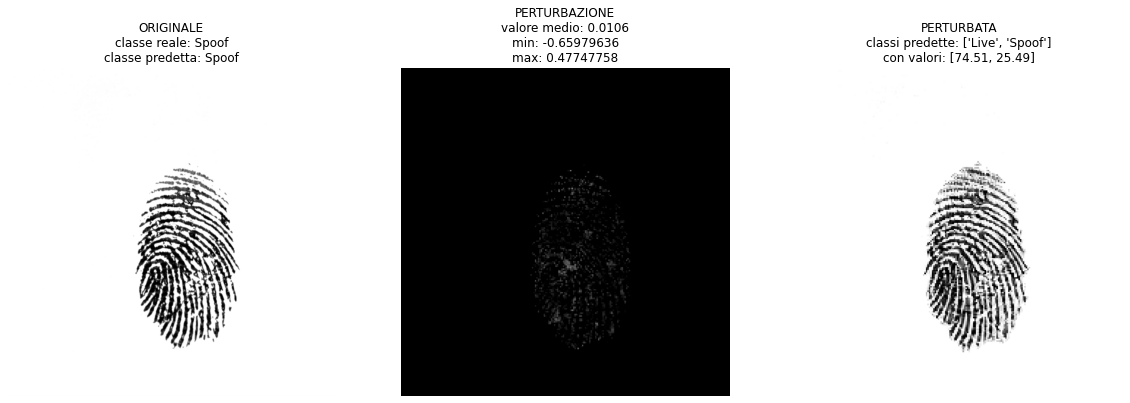

In [43]:
#da usare solo con dataset ridotto
preds_orig=[]
for input,_ in testgen:
  preds_orig_i,_,_=test_average(classifier,input)
  preds_orig.append(preds_orig_i)
preds_orig=np.array(preds_orig)
preds_orig=preds_orig[list_print]
print_subplot(perturb_print,x_print,y_print,preds_orig,x_print_adv,y_print_adv)

#salvataggio e lettura immagine

In [44]:
save_read(x_print_adv[0])

valori img originale:
(0, array([0.7451133, 0.2548867], dtype=float32), [0.7792326867580414, -0.29348459243774416])
valori dopo salvataggio/lettura:
(0, array([0.7499449 , 0.25005504], dtype=float32), [0.7920611053705215, -0.3062576174736023])
